# TFLite Training
https://github.com/liuyy3364/AAML_MCU_TinyML_Lab/blob/master/utils/train.py

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from keras.datasets import cifar10
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [79]:
#learning rate schedule
# def lr_schedule(epoch):
#   initial_learning_rate = 0.001
#   decay_per_epoch = 0.99
#   lrate = initial_learning_rate * (decay_per_epoch ** epoch)
#   print('Learning rate = %f'%lrate)
#   return lrate
def lr_schedule(epoch):
    initial_learning_rate = 0.001

    # 設置衰減的時間點
    if epoch >= 75:
        lrate = initial_learning_rate * 0.01  # Epoch 75 之後，降至 0.00001
    elif epoch >= 50:
        lrate = initial_learning_rate * 0.1   # Epoch 50 之後，降至 0.0001
    else:
        lrate = initial_learning_rate         # Epoch 0-49，保持 0.001

    print('Learning rate = %f' % lrate)
    return lrate

lr_scheduler = LearningRateScheduler(lr_schedule)

#optimizer
optimizer = tf.keras.optimizers.Adam()

#define data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

## load cifar10 data

In [80]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train , 10)
y_test = to_categorical(y_test , 10)

## show cifar 10 images

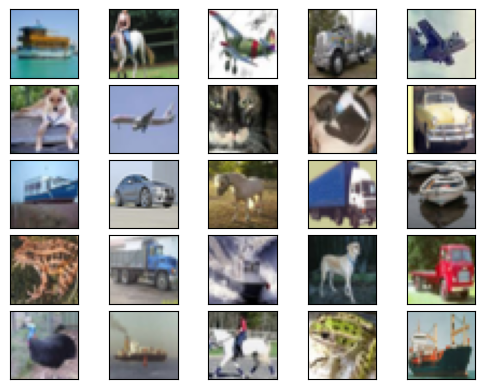

In [81]:
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
  for n in range(num_plot):
    idx = np.random.randint(0, x_train.shape[0])
    ax[m, n].imshow(x_train[idx])
    ax[m, n].get_xaxis().set_visible(False)
    ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()


## define model
https://github.com/mlcommons/tiny/blob/master/benchmark/training/image_classification/keras_model.py

In [82]:
def resnet_v1_eembc():
    # Resnet parameters
    input_shape=[32,32,3] # default size for cifar10
    num_classes=10 # default class number for cifar10
    num_filters = 16 # this should be 64 for an official resnet model

    # Input layer, change kernel size to 7x7 and strides to 2 for an official resnet
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x) # uncomment this for official resnet model


    # First stack

    # Weight layers
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Second stack

    # Weight layers
    num_filters = 32 # Filters need to be double for each stack
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Adjust for change in dimension due to stride in identity
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Third stack

    # Weight layers
    num_filters = 64
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Adjust for change in dimension due to stride in identity
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)

    # Final classification layer.
    pool_size = int(np.amin(x.shape[1:3]))
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# training

In [83]:
batch_size = 400
epochs = 100
save_model_name = "resnet_v1_eembc"

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 32, 32,    │        448 │ input_layer_16[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_144[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_112      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 32, 32,    │      2,320 │ activation_112[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_145[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_113      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 32, 32,    │      2,320 │ activation_113[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_146[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 32, 32,    │          0 │ activation_112[0… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_114      │ (None, 32, 32,    │          0 │ add_48[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 16, 16,    │      4,640 │ activation_114[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_147[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_115      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 16, 16,    │      9,248 │ activation_115[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 16, 16,    │        544 │ activation_114[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_148[0][0]

 Total params: 78,666 (307.29 KB)

 Trainable params: 78,186 (305.41 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.2814 - loss: 2.0706 - val_accuracy: 0.1916 - val_loss: 2.3626
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 259ms/step - accuracy: 0.4479 - loss: 1.5794 - val_accuracy: 0.3502 - val_loss: 1.8999
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.5136 - loss: 1.4173 - val_accuracy: 0.3986 - val_loss: 1.7754
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.5499 - loss: 1.3258 - val_accuracy: 0.4933 - val_loss: 1.4965
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.5749 - loss: 1.2490 - val_accuracy: 0.5602 - val_loss: 1.2842
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.5899 - loss: 1.2054 - val_accuracy: 0.5142 - val_loss: 1.4335
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.6082 - loss: 1.1572 - val_accuracy: 0.5569 - val_loss: 1.2949
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.6249 -

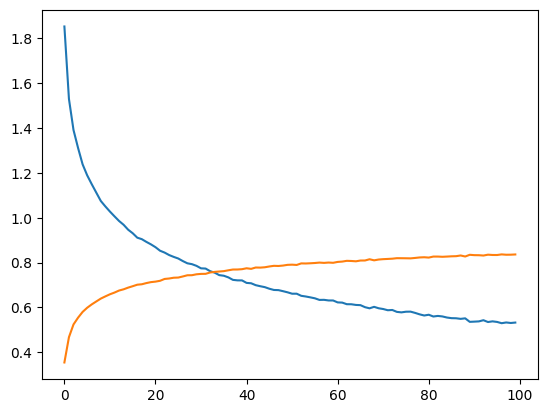

In [84]:
model = resnet_v1_eembc()
model.summary()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)


model.compile(
    optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=None,
    weighted_metrics=None, run_eagerly=None )

# fits the model on batches with real-time data augmentation:
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size,
         subset='training'),
         validation_data=datagen.flow(x_train, y_train,
         batch_size=batch_size, subset='validation'),
         steps_per_epoch=int(len(x_train) * 0.8 / batch_size), epochs=epochs)

plt.plot(np.array(range(epochs)), History.history['loss'])
plt.plot(np.array(range(epochs)), History.history['accuracy'])
plt.savefig('train_loss_acc.png')
# model_name = "trainedResnet.h5"
model.save(f"trained_models/{save_model_name}.h5")

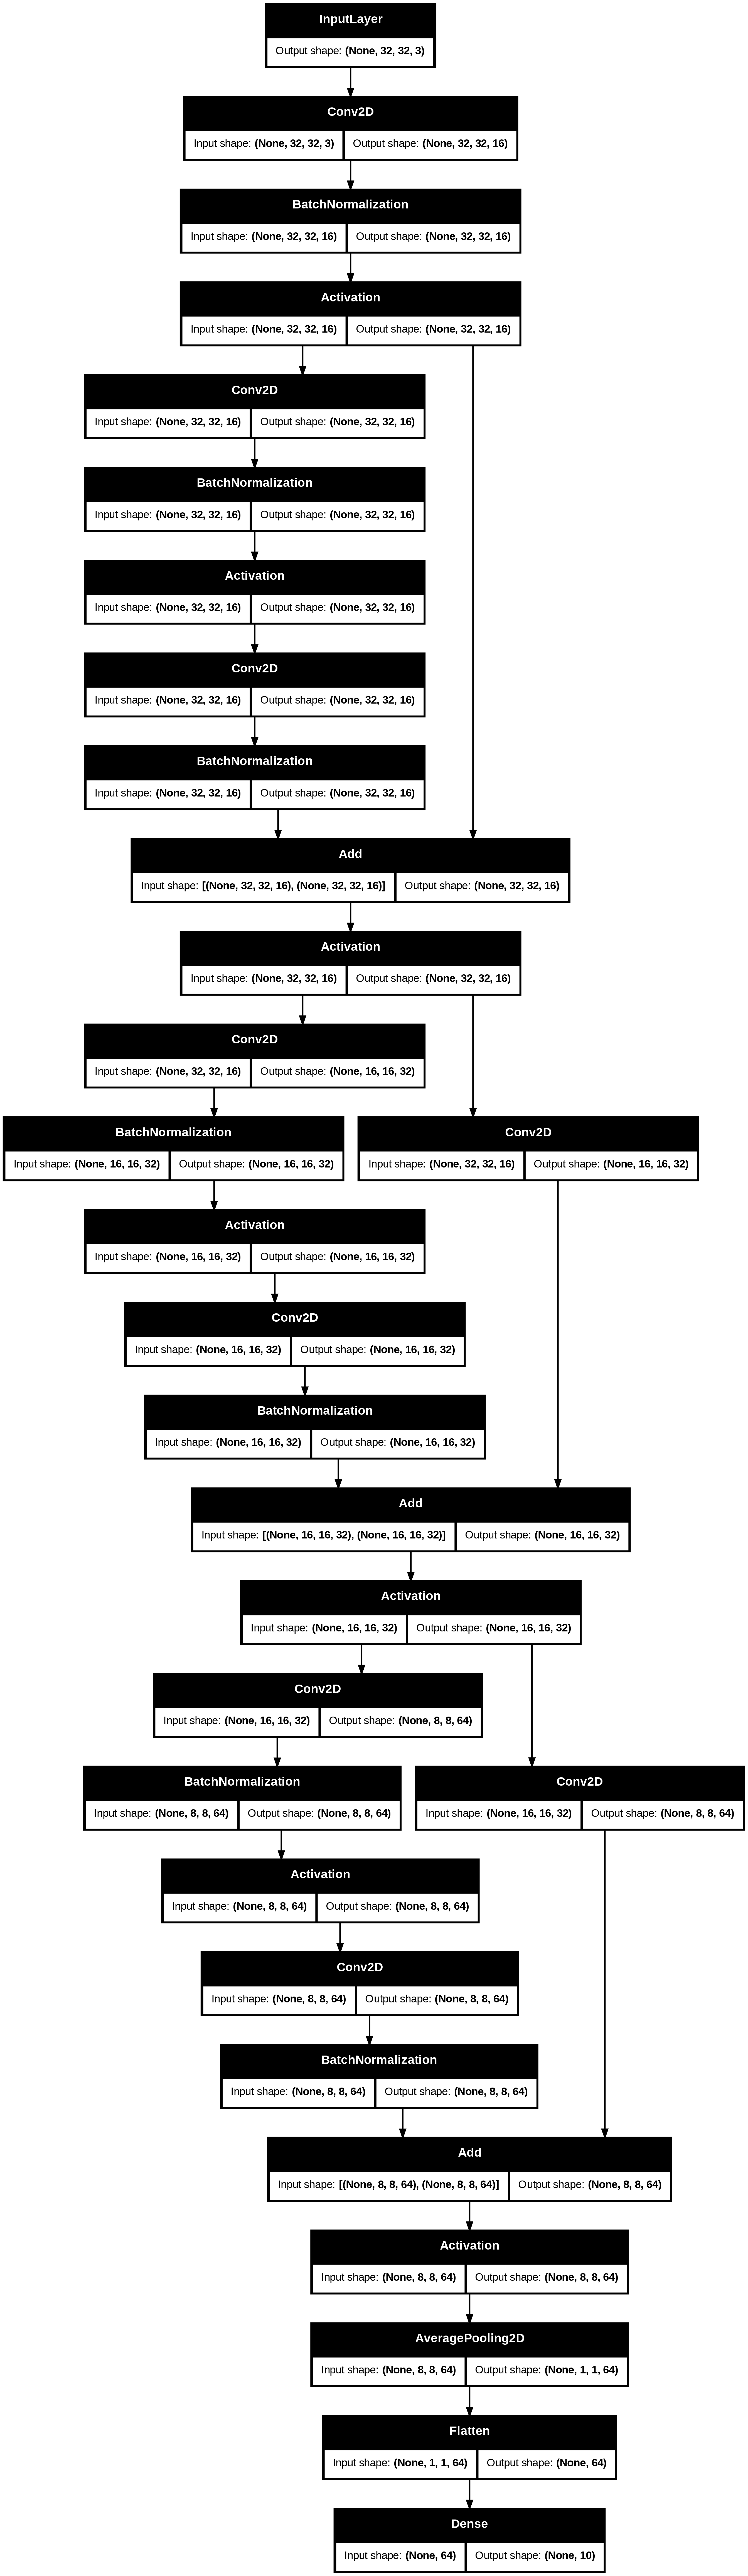

In [85]:
tf.keras.utils.plot_model(model , show_shapes=True , to_file=f"{save_model_name}.png")

In [86]:
!wget -O dog.jpg 'https://nextjournal.com/data/QmSAo4Nsf1fyxF79isKbaeF3f42LanxRyhUjwRd5SvFABA?content-type=image%2Fjpeg&filename=dog.jpg'

--2025-10-03 04:04:44--  https://nextjournal.com/data/QmSAo4Nsf1fyxF79isKbaeF3f42LanxRyhUjwRd5SvFABA?content-type=image%2Fjpeg&filename=dog.jpg
Resolving nextjournal.com (nextjournal.com)... 62.113.212.107
Connecting to nextjournal.com (nextjournal.com)|62.113.212.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660163 (645K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 644.69K   783KB/s    in 0.8s    

2025-10-03 04:04:45 (783 KB/s) - ‘dog.jpg’ saved [660163/660163]



In [87]:
from PIL import Image
img = np.array(Image.open("/content/dog.jpg").resize((32,32)))
pred = model.predict(np.expand_dims(img, axis=0))
print(pred)
print(np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
[[2.8453175e-09 8.2337965e-07 9.8169876e-05 1.7037663e-03 2.5229078e-06
  9.9811363e-01 1.0689068e-05 6.6262961e-05 2.0688847e-06 2.1086319e-06]]
5


## export model to tflite


In [88]:
keras_model = tf.keras.models.load_model(f'/content/trained_models/{save_model_name}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()
open(f'{save_model_name}.tflite', 'wb').write(tflite_model)

Saved artifact at '/tmp/tmpwarghbzo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_16')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138630989888400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138630996092368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138630996093712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138630996093136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138630996091600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138630996093520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628596429264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628596430416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628596431568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628596428496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1386285964323

319400

## export with quantization int8

In [89]:
def representative_dataset_generator():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  for i in range(3000):
    sample_img = np.expand_dims(np.array(x_train[i], dtype=np.float32), axis=0)
    yield [sample_img]

keras_model = tf.keras.models.load_model(f'/content/trained_models/{save_model_name}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset_generator
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()
open(f'{save_model_name}_quant.tflite', 'wb').write(tflite_quant_model)

Saved artifact at '/tmp/tmpa47wp__i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_16')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138632908037328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631777303056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631777293456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631777303632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631777303824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631777304400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631777303248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631777304016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631771734480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631771735440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1386317773042

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


96792

## check model output

In [90]:
data_input = np.expand_dims(img.astype(np.float32), axis=0)
data_input_quant = np.expand_dims(img, axis=0)

In [91]:
# normal
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input = interpreter.get_input_details()[0]
output = interpreter.get_output_details()[0]
# img.astype(np.float32)
interpreter.set_tensor(input['index'], data_input)
interpreter.invoke()
print(interpreter.get_tensor(output['index']))
print(np.argmax(interpreter.get_tensor(output['index'])))

[[2.84533330e-09 8.23381015e-07 9.81705161e-05 1.70376920e-03
  2.52291738e-06 9.98113513e-01 1.06890875e-05 6.62631428e-05
  2.06888831e-06 2.10863550e-06]]
5


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [92]:
# quant
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input = interpreter.get_input_details()[0]
output = interpreter.get_output_details()[0]

interpreter.set_tensor(input['index'], data_input_quant)
interpreter.invoke()
print(interpreter.get_tensor(output['index']))
print(np.argmax(interpreter.get_tensor(output['index'])))

[[  0   0   0   0   0 255   0   0   0   0]]
5
